# dgl tutorial

[dgl official heterogeneousgraph](https://docs.dgl.ai/en/latest/guide/message-heterograph.html)

[dgl meesgae passing](https://docs.dgl.ai/en/latest/guide/message-api.html)

In DGL, message function takes a single argument edges, which is an EdgeBatch instance. During message passing, DGL generates it internally to represent a batch of edges. It has three members src, dst and data to access features of source nodes, destination nodes, and edges, respectively.

reduce function takes a single argument `nodes`, which is a `NodeBatch` instance. During message passing, DGL generates it internally to represent a batch of nodes. It has member `mailbox` to access the messages received for the nodes in the batch. Some of the most common reduce operations include __sum, max, min, etc.__

update function takes a single argument `nodes` as described above. This function operates on the aggregation result from `reduce function`, typically combining it with a node’s original feature at the the last step and saving the result as a node feature.

Built-in message functions can be unary or binary. 

DGL supports `copy` for unary. For binary funcs, DGL supports `add`, `sub`, `mul`, `div`, `dot`. 

__The naming convetnion for message built-in funcs is that `u` represents `src` nodes, `v` represents `dst` nodes, and `e` represents `edges`.__

[built-in function box](https://docs.dgl.ai/en/latest/api/python/dgl.function.html#api-built-in)

In [2]:
def message_func(edges):
    return {'he': edges.src['hu'] + edges.dst['hv']}

def reduce_func(nodes):
    return {'h': torch.sum(nodes.mailbox['m'], dim=1)}
# torch.max , torch.min etc 

# edge-wise computation example

# graph.apply_edges(fn.u_add_v('el', 'er', 'e'))

def update_all_example(graph):
    # store the result in graph.ndata['ft']
    graph.update_all(fn.u_mul_e('ft', 'a', 'm'),
                    fn.sum('m', 'ft'))
    
    final_ft = graph.ndata['ft'] * 2
    return final_ft

This call will generate the messages `m` by multiply src node features `ft` and edge features `a`, sum up the messages `m` to update node features `ft`, and finally multiply `ft` by 2 to get the result `final_ft`. After the call, DGL will clean the intermediate message `m`.

$$final_ft_i = 2 * \sum_{j \in N(i)}(ft_j*a_{ji})$$

In [4]:
# # canonical etype ; https://docs.dgl.ai/en/latest/generated/dgl.DGLGraph.canonical_etypes.html
# for c_etype in G.canonical_etype:
#     srctype, etype, dsttype = c_etype
#     Wh = self.weight[etype](feat_dict[srctype])
#     # save it in graph for message passing
#     G.nodes[srctype].data['Wh_%s' % etype] = Wh
#     # Specifiy per-relation message passing functions:
#     ## message_func , reduce_func
#     # note that the results are saved to the same destination feature `h`,
#     ## which hints the type wise reducer for aggregation
#     funcs[etype] = (fn.copy_u('Wh_%s' % etype, 'm'), fn.mean('m', 'h'))
# # Trigger message passing of multiple types
# G.multi_update_all(funcs, 'sum')
# # return the updated node feature dictionary
# return {ntype : G.nodes[ntype].data['h'] for ntype in G.ntypes}

In [7]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
torch.cuda.empty_cache()

you can see that message passing is directional: 

the message sent from one node ; `math 'u'` to other `node 'v'` is not necessarily the same as the other message sent from `node 'v'` to `node 'u'` in the opposite direction.

## GRAPHSAGE

In [12]:
class SAGEConv(nn.Module):
    """Graph convolution module used by the GraphSAGE model.
    
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    """
    def __init__(self, in_feat, out_feat):
        super(SAGEConv, self).__init__()
        # A linear submodule for projecting the input and neighbor feature to the output.
        self.linear = nn.Linear(in_feat * 2, out_feat)
    
    def forward(self, g, h):
        """Forward computation
        
        Parameters
        ----------
        g : Graph
            The input graph.
        h : Tensor
            The input node feature.
        """
        with g.local_scope():
            g.ndata['h'] = h
            # update_all is a message passing API.
            g.update_all(message_func=fn.copy_u('h', 'm'),
                         reduce_func=fn.mean('m', 'h_N'))
            # g.edata['w'] = w
            # g.update_all(message_func=fn.mul_e('h','w','m'),
            #              reduce_func=fn.mean('m', 'h_N'))
            h_N = g.ndata['h_N']
            h_total = torch.cat([h, h_N], dim=1)
            return self.linear(h_total)

# func box https://docs.dgl.ai/en/0.8.x/api/python/dgl.function.html            
##########################################################################
# The central piece in this code is the
# :func:`g.update_all <dgl.DGLGraph.update_all>`
# function, which gathers and averages the neighbor features. There are
# three concepts here:
#
# * Message function ``fn.copy_u('h', 'm')`` that
#   copies the node feature under name ``'h'`` as *messages* with name
#   ``'m'`` sent to neighbors.
#
# * Reduce function ``fn.mean('m', 'h_N')`` that averages
#   all the received messages under name ``'m'`` and saves the result as a
#   new node feature ``'h_N'``.
#
# * ``update_all`` tells DGL to trigger the
#   message and reduce functions for all the nodes and edges.
# 

In [13]:
class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        self.conv2 = SAGEConv(h_feats, num_classes)
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [14]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    all_logits = []
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(200):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that we should only compute the losses of the nodes in the training set,
        # i.e. with train_mask 1.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_logits.append(logits.detach())

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))

model = Model(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
In epoch 0, loss: 1.952, val acc: 0.162 (best 0.162), test acc: 0.149 (best 0.149)
In epoch 5, loss: 1.892, val acc: 0.162 (best 0.162), test acc: 0.149 (best 0.149)
In epoch 10, loss: 1.773, val acc: 0.406 (best 0.406), test acc: 0.393 (best 0.393)
In epoch 15, loss: 1.593, val acc: 0.464 (best 0.464), test acc: 0.465 (best 0.465)
In epoch 20, loss: 1.353, val acc: 0.536 (best 0.536), test acc: 0.547 (best 0.547)
In epoch 25, loss: 1.074, val acc: 0.610 (best 0.610), test acc: 0.632 (best 0.632)
In epoch 30, loss: 0.790, val acc: 0.658 (best 0.658), test acc: 0.682 (best 0.682)
In epoch 35, loss: 0.540, val acc: 0.704 (best 0.704), test acc: 0.720 (best 0.720)
In epoch 40, loss: 0.348, val acc: 0.736 (best 0.736), test acc: 0.741 (best 0.741)
In epoch 45, loss: 0.217, val acc: 0.748 (best 0.748), test acc:

## RGCN


### equation (1)

$$ h_i^{l+1} = \sigma\left(\sum_{j\in N_i}\frac{1}{c_i} W^{(l)} h_j^{(l)}\right) $$

### equation (2)

$$ h_i^{l+1} = \sigma\left(W_0^{(l)}h_i^{(l)}+\sum_{r\in R}\sum_{j\in N_i^r}\frac{1}{c_{i,r}}W_r^{(l)}h_j^{(l)}\right) $$

### equation (3)

The problem of applying the above equation directly is the rapid growth of
the number of parameters, especially with highly multi-relational data. In
order to reduce model parameter size and prevent overfitting, the original
paper proposes to use basis decomposition.

$$ W_r^{(l)}=\sum\limits_{b=1}^B a_{rb}^{(l)}V_b^{(l)} $$ 

where `V_b` are the basis matrics , `a_{rb}` is the importance weight of matrix `V_b`

--> 
__Share weights across different relations__

In [15]:
from dgl import DGLGraph
from functools import partial

In [16]:
class RGCNLayer(nn.Module):
    def __init__(self, in_feat, out_feat, num_rels, num_bases=-1, bias=None,
                 activation=None, is_input_layer=False):
        super(RGCNLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.num_rels = num_rels
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.is_input_layer = is_input_layer

        # sanity check
        if self.num_bases <= 0 or self.num_bases > self.num_rels:
            self.num_bases = self.num_rels

        # weight bases in equation (3)
        self.weight = nn.Parameter(torch.Tensor(self.num_bases, self.in_feat,
                                                self.out_feat))
        if self.num_bases < self.num_rels:
            # linear combination coefficients in equation (3)
            self.w_comp = nn.Parameter(torch.Tensor(self.num_rels, self.num_bases))

        # add bias
        if self.bias:
            self.bias = nn.Parameter(torch.Tensor(out_feat))

## from pytorch discussion
# The gain is a scaling factor for some init functions, e.g. xavier init 116.
# It’s used to scale the standard deviation with respect to the applied non-linearity.
# Since the non-linearity will affect the std dev of the activation, 
# you might run into some issues,
# e.g. vanishing gradients. The gain with respect to the non-linearity should give you “good” statistics of your activations. 

        # init trainable parameters
        nn.init.xavier_uniform_(self.weight,
                                gain=nn.init.calculate_gain('relu'))
        if self.num_bases < self.num_rels:
            nn.init.xavier_uniform_(self.w_comp,
                                    gain=nn.init.calculate_gain('relu'))
        if self.bias:
            nn.init.xavier_uniform_(self.bias,
                                    gain=nn.init.calculate_gain('relu'))

    def forward(self, g):
        if self.num_bases < self.num_rels:
            # generate all weights from bases (equation (3))
            weight = self.weight.view(self.in_feat, self.num_bases, self.out_feat)
            weight = torch.matmul(self.w_comp, weight).view(self.num_rels,
                                                        self.in_feat, self.out_feat)
        else:
            weight = self.weight

        if self.is_input_layer:
            def message_func(edges):
                # for input layer, matrix multiply can be converted to be
                # an embedding lookup using source node id
                embed = weight.view(-1, self.out_feat)
                index = edges.data['rel_type'] * self.in_feat + edges.src['id']
                return {'msg': embed[index] * edges.data['norm']}
        else:
            def message_func(edges):
                w = weight[edges.data['rel_type']]
                msg = torch.bmm(edges.src['h'].unsqueeze(1), w).squeeze()
                msg = msg * edges.data['norm']
                return {'msg': msg}

        def apply_func(nodes):
            h = nodes.data['h']
            if self.bias:
                h = h + self.bias
            if self.activation:
                h = self.activation(h)
            return {'h': h}

        g.update_all(message_func, fn.sum(msg='msg', out='h'), apply_func)

In [17]:
class Model(nn.Module):
    def __init__(self, num_nodes, h_dim, out_dim, num_rels,
                 num_bases=-1, num_hidden_layers=1):
        super(Model, self).__init__()
        self.num_nodes = num_nodes
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.num_rels = num_rels
        self.num_bases = num_bases
        self.num_hidden_layers = num_hidden_layers

        # create rgcn layers
        self.build_model()

        # create initial features
        self.features = self.create_features()

    def build_model(self):
        self.layers = nn.ModuleList()
        # input to hidden
        i2h = self.build_input_layer()
        self.layers.append(i2h)
        # hidden to hidden
        for _ in range(self.num_hidden_layers):
            h2h = self.build_hidden_layer()
            self.layers.append(h2h)
        # hidden to output
        h2o = self.build_output_layer()
        self.layers.append(h2o)

    # initialize feature for each node
    def create_features(self):
        features = torch.arange(self.num_nodes)
        return features

    def build_input_layer(self):
        return RGCNLayer(self.num_nodes, self.h_dim, self.num_rels, self.num_bases,
                         activation=F.relu, is_input_layer=True)

    def build_hidden_layer(self):
        return RGCNLayer(self.h_dim, self.h_dim, self.num_rels, self.num_bases,
                         activation=F.relu)

    def build_output_layer(self):
        return RGCNLayer(self.h_dim, self.out_dim, self.num_rels, self.num_bases,
                         activation=partial(F.softmax, dim=1))

    def forward(self, g):
        if self.features is not None:
            g.ndata['id'] = self.features
        for layer in self.layers:
            layer(g)
        return g.ndata.pop('h')

In [18]:
# load graph data
from dgl.contrib.data import load_data
data = load_data(dataset='aifb')
num_nodes = data.num_nodes
num_rels = data.num_rels
num_classes = data.num_classes
labels = data.labels
train_idx = data.train_idx
# split training and validation set
val_idx = train_idx[:len(train_idx) // 5]
train_idx = train_idx[len(train_idx) // 5:]

# edge type and normalization factor
edge_type = torch.from_numpy(data.edge_type)
edge_norm = torch.from_numpy(data.edge_norm).unsqueeze(1)

labels = torch.from_numpy(labels).view(-1)

Loading dataset aifb
Number of nodes:  8285
Number of edges:  66371
Number of relations:  91
Number of classes:  4
removing nodes that are more than 3 hops away


In [19]:
# configurations
n_hidden = 16 # number of hidden units
n_bases = -1 # use number of relations as number of bases
n_hidden_layers = 0 # use 1 input layer, 1 output layer, no hidden layer
n_epochs = 25 # epochs to train
lr = 0.01 # learning rate
l2norm = 0 # L2 norm coefficient

# create graph
g = DGLGraph((data.edge_src, data.edge_dst))
g.edata.update({'rel_type': edge_type, 'norm': edge_norm})

# create model
model = Model(g.num_nodes(),
              n_hidden,
              num_classes,
              num_rels,
              num_bases=n_bases,
              num_hidden_layers=n_hidden_layers)

/home/ubuntu/anaconda3/envs/graph/lib/python3.9/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [20]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2norm)
train_box = []
val_box = []
print("start training...")
model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    logits = model.forward(g)
    loss = F.cross_entropy(logits[train_idx], labels[train_idx])
    loss.backward()

    optimizer.step()

    train_acc = torch.sum(logits[train_idx].argmax(dim=1) == labels[train_idx])
    train_acc = train_acc.item() / len(train_idx)
    train_box.append(loss)
    val_loss = F.cross_entropy(logits[val_idx], labels[val_idx])
    val_box.append(val_loss)
    val_acc = torch.sum(logits[val_idx].argmax(dim=1) == labels[val_idx])
    val_acc = val_acc.item() / len(val_idx)
    print("Epoch {:05d} | ".format(epoch) +
          "Train Accuracy: {:.4f} | Train Loss: {:.4f} | ".format(
              train_acc, loss.item()) +
          "Validation Accuracy: {:.4f} | Validation loss: {:.4f}".format(
              val_acc, val_loss.item()))

start training...
Epoch 00000 | Train Accuracy: 0.1786 | Train Loss: 1.3862 | Validation Accuracy: 0.3929 | Validation loss: 1.3855
Epoch 00001 | Train Accuracy: 0.9464 | Train Loss: 1.3400 | Validation Accuracy: 1.0000 | Validation loss: 1.3538
Epoch 00002 | Train Accuracy: 0.9375 | Train Loss: 1.2698 | Validation Accuracy: 1.0000 | Validation loss: 1.3065
Epoch 00003 | Train Accuracy: 0.9375 | Train Loss: 1.1804 | Validation Accuracy: 1.0000 | Validation loss: 1.2438
Epoch 00004 | Train Accuracy: 0.9375 | Train Loss: 1.0894 | Validation Accuracy: 1.0000 | Validation loss: 1.1704
Epoch 00005 | Train Accuracy: 0.9375 | Train Loss: 1.0115 | Validation Accuracy: 1.0000 | Validation loss: 1.0930
Epoch 00006 | Train Accuracy: 0.9464 | Train Loss: 0.9489 | Validation Accuracy: 1.0000 | Validation loss: 1.0190
Epoch 00007 | Train Accuracy: 0.9464 | Train Loss: 0.8998 | Validation Accuracy: 1.0000 | Validation loss: 0.9550
Epoch 00008 | Train Accuracy: 0.9464 | Train Loss: 0.8628 | Validation

# data overview

[Xente official website](https://www.xente.co/)

[dataset](https://zindi.africa/competitions/xente-fraud-detection-challenge/submissions)

Xente is an e-commerce and financial service app serving 10,000+ customers in Uganda.

In [23]:
import os, sys
from copy import deepcopy
import numpy as np
import pandas as pd
import networkx as nx

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl import function as fn
from dgl.dataloading import DataLoader

In [24]:
!cat dataset/Xente_Variable_Definitions.csv

Column Name,Definition
TransactionId,Unique �transaction identifier on platform
BatchId,Unique number assigned to a batch of transactions for processing
AccountId,Unique number identifying the customer on platform
SubscriptionId,Unique number identifying the customer subscription
CustomerId,Unique identifier attached to Account
CurrencyCode,Country currency
CountryCode,Numerical geographical code of country
ProviderId,Source provider of Item �bought.
ProductId,Item name being bought.
ProductCategory,ProductIds are organized into these broader product categories.
ChannelId,"Identifies if customer used web,Android, IOS, pay later or checkout."
Amount,Value of the transaction. Positive for debits from customer account and negative for credit into customer account
Value,Absolute value of the amount
TransactionStartTime,Transaction start time
PricingStrategy,Category of Xente's pricing structure for merchants
FraudResult,Fraud status of transaction 1 -yes or 0-No


In [25]:
!mkdir -p models

In [26]:
%ls dataset/

sample_submission.csv  test.csv  training.csv  Xente_Variable_Definitions.csv


In [27]:
df_train = pd.read_csv('dataset/training.csv')
df_test = pd.read_csv('dataset/test.csv')

In [28]:
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

In [29]:
df = pd.concat([df_train,df_test],axis=0)

In [30]:
df['dataset'].value_counts()

train    95662
test     45019
Name: dataset, dtype: int64

In [31]:
df.groupby('dataset').nunique().T

dataset,test,train
TransactionId,45019,95662
BatchId,44684,94809
AccountId,2471,3633
SubscriptionId,2470,3627
CustomerId,5018,3742
CurrencyCode,1,1
CountryCode,1,1
ProviderId,6,6
ProductId,26,23
ProductCategory,9,9


In [32]:
df_train['FraudResult'].value_counts()

0    95469
1      193
Name: FraudResult, dtype: int64

- transactionid ; unique key 

- the others are auxiliary feature in this task.

- `Amount` can be used to indicate credit/debit, and `Value` can be a numerical feature

# construct a graph

## preprocessing procedure , mapping

In [33]:
df.head(1)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,dataset
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0.0,train


In [34]:
def column_index(series, offset=0):
    return {k: v+offset for v, k in enumerate(series.value_counts().index.values)}

In [35]:
# Tx , Accu , Subscritipion , Cust 

txn2idx = {v: idx for idx, v in enumerate(df['TransactionId'].values)}
acct2idx = column_index(df['AccountId'])
sub2idx = column_index(df['SubscriptionId'])
cust2idx = column_index(df['CustomerId'])

In [36]:
df['txnIdx'] = df['TransactionId'].map(txn2idx)
df = df.sort_values(by='txnIdx')
df['acctIdx'] = df['AccountId'].map(acct2idx)
df['subIdx'] = df['SubscriptionId'].map(sub2idx)
df['custIdx'] = df['CustomerId'].map(cust2idx)

In [37]:
y_txn = df.sort_values(by='txnIdx')['FraudResult'].values
baseline = y_txn[y_txn>=0].mean()
node_id_cols = ['txnIdx', 'subIdx', 'acctIdx']
N_nodes = df[node_id_cols].nunique().sum()

In [38]:
## high imbalanced data
display(df[df[df['FraudResult'].notnull()]['FraudResult'] == 0.0])
# 140414
display(df[df[df['FraudResult'].notnull()]['FraudResult'] == 1.0])
# 267

/tmp/ipykernel_32566/1581865461.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[df[df['FraudResult'].notnull()]['FraudResult'] == 0.0])


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,dataset,txnIdx,acctIdx,subIdx,custIdx
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,1000.0,1000,2018-11-15T02:18:49Z,2,0.0,train,0,209,207,161
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,-20.0,20,2018-11-15T02:19:08Z,2,0.0,train,1,0,0,161
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,500.0,500,2018-11-15T02:44:21Z,2,0.0,train,2,3660,3658,4066
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,20000.0,21800,2018-11-15T03:32:55Z,2,0.0,train,3,536,551,544
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,-644.0,644,2018-11-15T03:34:21Z,2,0.0,train,4,0,0,544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45014,TransactionId_116198,BatchId_117348,AccountId_4841,SubscriptionId_3829,CustomerId_5225,UGX,256,ProviderId_4,ProductId_6,financial_services,...,-5000.0,5000,2019-03-14T23:56:28Z,2,NaN,test,140676,0,0,731
45015,TransactionId_24829,BatchId_53630,AccountId_4803,SubscriptionId_1738,CustomerId_5272,UGX,256,ProviderId_3,ProductId_10,airtime,...,10000.0,10000,2019-03-14T23:57:38Z,1,NaN,test,140677,806,790,762
45016,TransactionId_102920,BatchId_112209,AccountId_4817,SubscriptionId_4613,CustomerId_5286,UGX,256,ProviderId_3,ProductId_10,airtime,...,10000.0,10000,2019-03-14T23:59:17Z,1,NaN,test,140678,603,601,555
45017,TransactionId_128439,BatchId_58734,AccountId_4841,SubscriptionId_3829,CustomerId_5286,UGX,256,ProviderId_4,ProductId_6,financial_services,...,-5000.0,5000,2019-03-14T23:59:39Z,2,NaN,test,140679,0,0,555


/tmp/ipykernel_32566/1581865461.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[df[df['FraudResult'].notnull()]['FraudResult'] == 1.0])


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,dataset,txnIdx,acctIdx,subIdx,custIdx
131,TransactionId_60873,BatchId_93685,AccountId_3832,SubscriptionId_4161,CustomerId_4275,UGX,256,ProviderId_3,ProductId_15,financial_services,...,700000.0,700000,2018-11-15T08:04:51Z,0,1.0,train,131,1842,1925,2267
146,TransactionId_28016,BatchId_125553,AccountId_2366,SubscriptionId_4834,CustomerId_7414,UGX,256,ProviderId_5,ProductId_9,financial_services,...,725000.0,725000,2018-11-15T08:20:09Z,2,1.0,train,146,1680,1698,3767
155,TransactionId_1149,BatchId_10381,AccountId_3832,SubscriptionId_4161,CustomerId_4275,UGX,256,ProviderId_3,ProductId_15,financial_services,...,700000.0,700000,2018-11-15T08:31:57Z,0,1.0,train,155,1842,1925,2267
2376,TransactionId_136904,BatchId_52644,AccountId_3692,SubscriptionId_3451,CustomerId_4134,UGX,256,ProviderId_1,ProductId_15,financial_services,...,700000.0,700000,2018-11-17T09:15:23Z,0,1.0,train,2376,4002,4001,6380
2452,TransactionId_88818,BatchId_54481,AccountId_3832,SubscriptionId_4161,CustomerId_4275,UGX,256,ProviderId_3,ProductId_15,financial_services,...,700000.0,700000,2018-11-17T11:49:46Z,0,1.0,train,2452,1842,1925,2267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42243,TransactionId_87550,BatchId_6182,AccountId_3637,SubscriptionId_1911,CustomerId_4076,UGX,256,ProviderId_6,ProductId_10,airtime,...,3000.0,3000,2019-03-12T17:24:36Z,2,NaN,test,137905,31,30,23
42248,TransactionId_100388,BatchId_98191,AccountId_3204,SubscriptionId_4675,CustomerId_3632,UGX,256,ProviderId_6,ProductId_14,financial_services,...,595.0,595,2019-03-12T17:27:46Z,2,NaN,test,137910,898,934,838
42258,TransactionId_40528,BatchId_65495,AccountId_4052,SubscriptionId_4536,CustomerId_4502,UGX,256,ProviderId_6,ProductId_3,airtime,...,1000.0,1000,2019-03-12T17:38:54Z,2,NaN,test,137920,88,87,66
42259,TransactionId_120840,BatchId_48798,AccountId_3241,SubscriptionId_2893,CustomerId_3669,UGX,256,ProviderId_6,ProductId_10,airtime,...,1500.0,1500,2019-03-12T17:39:39Z,2,NaN,test,137921,831,830,720


In [39]:
N_labels = df[df['dataset']=='train'].shape[0]

## edge build

In [40]:
from itertools import combinations

In [41]:
edge_dict = dict()

for src_type, dst_type in combinations(node_id_cols, 2):
    fwd = (src_type, f'{src_type}-{dst_type}' , dst_type)
    bwd = (dst_type, f'{dst_type}-{src_type}' , src_type)
    print(fwd)
    print(bwd)
    print('#' * 50)
    
    edges = df[[src_type, dst_type]].drop_duplicates().values
    src = edges[:, 0]
    dst = edges[:, 1]
    
    edge_dict[fwd] = (th.tensor(src), th.tensor(dst))
    edge_dict[bwd] = (th.tensor(dst), th.tensor(src))

('txnIdx', 'txnIdx-subIdx', 'subIdx')
('subIdx', 'subIdx-txnIdx', 'txnIdx')
##################################################
('txnIdx', 'txnIdx-acctIdx', 'acctIdx')
('acctIdx', 'acctIdx-txnIdx', 'txnIdx')
##################################################
('subIdx', 'subIdx-acctIdx', 'acctIdx')
('acctIdx', 'acctIdx-subIdx', 'subIdx')
##################################################


In [42]:
hg = dgl.heterograph(edge_dict)

In [43]:
print(hg.metagraph().nodes(), '\n\n')
print(hg.metagraph().edges(), f'\n\n there are {len(hg.metagraph().edges())} relations existing.')

['acctIdx', 'subIdx', 'txnIdx'] 


[('acctIdx', 'subIdx'), ('acctIdx', 'txnIdx'), ('subIdx', 'acctIdx'), ('subIdx', 'txnIdx'), ('txnIdx', 'acctIdx'), ('txnIdx', 'subIdx')] 

 there are 6 relations existing.


In [44]:
label_feat = dict()

# Based on original label, making the label feature.
for ntype in hg.ntypes:
    if ntype=='txnIdx':
        continue
    label_feat[ntype] = th.zeros(hg.number_of_nodes(ntype)) + baseline
    
# nan to num for labeling.
label_feat['txnIdx'] = th.tensor(np.nan_to_num(y_txn, nan=baseline)).float()

In [45]:
hg.ndata['label'] = label_feat

In [46]:
# results
label_feat

{'acctIdx': tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]),
 'subIdx': tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]),
 'txnIdx': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0020, 0.0020, 0.0020])}

In [47]:
y_txn.shape

(140681,)

In [48]:
assert hg.number_of_nodes('txnIdx')==y_txn.shape[0]
assert (df['FraudResult']==1).sum() == (dgl.to_homogeneous(hg, ndata=['label']).ndata['label']==1).sum().item()

In [49]:
print(hg.canonical_etypes)

[('acctIdx', 'acctIdx-subIdx', 'subIdx'), ('acctIdx', 'acctIdx-txnIdx', 'txnIdx'), ('subIdx', 'subIdx-acctIdx', 'acctIdx'), ('subIdx', 'subIdx-txnIdx', 'txnIdx'), ('txnIdx', 'txnIdx-acctIdx', 'acctIdx'), ('txnIdx', 'txnIdx-subIdx', 'subIdx')]


In [50]:
def draw_kkl_hg(hg, **kwargs):
    
    hg_label = hg.ndata['label']['txnIdx'].int()
    # for draw the newtork , we converted the hetero -> homo
    g = dgl.to_homogeneous(hg)
    g.ndata['ntype'] = g.ndata['_TYPE']
    nx_G = g.to_networkx(node_attrs=['ntype']).to_undirected()
    fig, ax = plt.subplots(figsize=(10,10))
    # https://frhyme.github.io/python-lib/networkx_layout/ 
    ## i guess you might to learn the layout knowledge more in above link.
    pos = nx.spring_layout(nx_G, k=5/np.sqrt(g.num_nodes()))
    
    nodeShapes = ['^','s', 'o','v']
    
    for idx, ntype in enumerate(hg.ntypes):
        aShape = nodeShapes[idx]
        if ntype == 'txnIdx':
            node_color = ['blue' if v==0 else 'red' if v ==1 else 'black' for v in hg_label]
        else:
            node_color = 'grey'
        nx.draw_networkx_nodes(
            nx_G, pos, node_shape=aShape, node_color=node_color, cmap='bwr', node_size=200,
            nodelist=[sNode[0] for sNode in filter(lambda x : x[1]['ntype']==idx, nx_G.nodes(data=True))]
        )
        
    nx.draw_networkx_edges(nx_G, pos)

In [51]:
def plot_neighborhood(dataloader, N_plots=5):
    nstats = dict()
    for i, (input_nodes, output_nodes, block) in enumerate(dataloader):
        if i >= N_plots:
            break
        # node_subgraph
        hg_tmp = dgl.node_subgraph(hg, input_nodes)
        draw_kkl_hg(hg_tmp)

In [52]:
def neighborhood_stats(hg):
    def mp_fn_dict(in_feat, out_feat):
        return{
            cetype: (fn.copy_u(in_feat, 'm'), fn.sum('m', out_feat))
            for cetype in hg.canonical_etypes
        }
    # local_scope avoids changing the graph features when exiting the function.
    with hg.local_scope():
        degree_data = dict()
        for ntype in hg.ntypes:
            in_degrees = th.zeros(hg.num_nodes(ntype))
            for cetype in hg.canonical_etypes:
                if cetype[2] == ntype:
                    print(cetype)
                    in_degrees += hg.in_degrees(etype=cetype)
            degree_data[ntype] = in_degrees
        
        hg.ndata['degree'] = degree_data
        hg.ndata['N_fraud'] = {
            ntype: (labels==1).float() for ntype, labels in hg.ndata['label'].items()
        }
        
        hg.multi_update_all(mp_fn_dict('degree', 'd_sum'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('N_fraud', 'total_fraud'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('total_fraud', 'total_fraud_2hop'), cross_reducer='sum')
        
        n_2hop = hg.ndata['d_sum']['txnIdx']
        fraud_rate_2hop = hg.ndata['total_fraud_2hop']['txnIdx'] / hg.ndata['d_sum']['txnIdx']
    return n_2hop, fraud_rate_2hop

In [53]:
# (n_hops are parameter what you want to watched your sampler of neighborhood)
n_hops = 2
# argument, MultiLayerNeighborSampler
## sampler = dgl.dataloading.MultiLayerNeighborSampler([15, 10, 5])
## above MultiLayerNeighborSampler func means frist layer extraction 15, second 10 , third 5 

sampler = dgl.dataloading.MultiLayerNeighborSampler([10] * n_hops)
# in this func each neighborhood 10 things for each layer

In [54]:
dataloader_legit = DataLoader(hg, {'txnIdx': np.where(y_txn==0)[0]}, sampler,
                             batch_size=1, shuffle=False, drop_last=False, num_workers=0)

In [55]:
dataloader_legit

- Circles = transactions

- blue=legit, red=fraud, black=unlabeled

- Triangle-Up = accounts

- Square = subscriptions

## normal

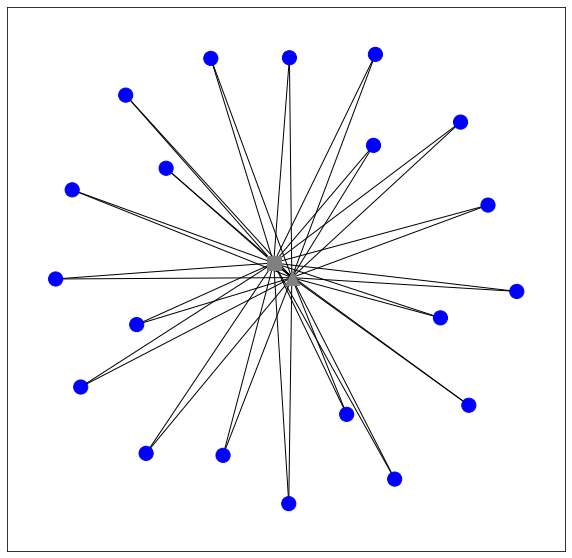

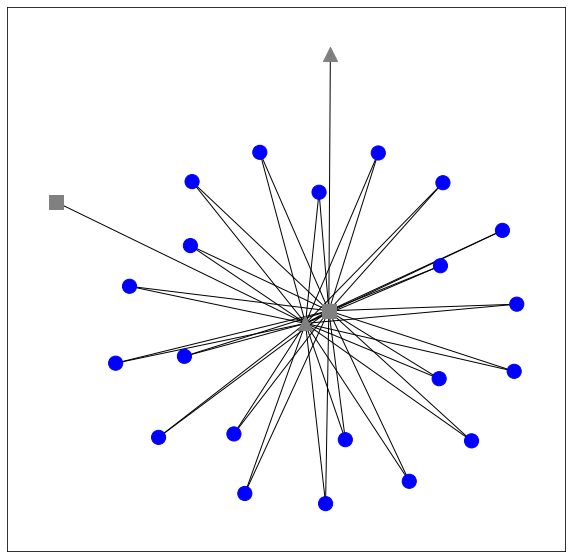

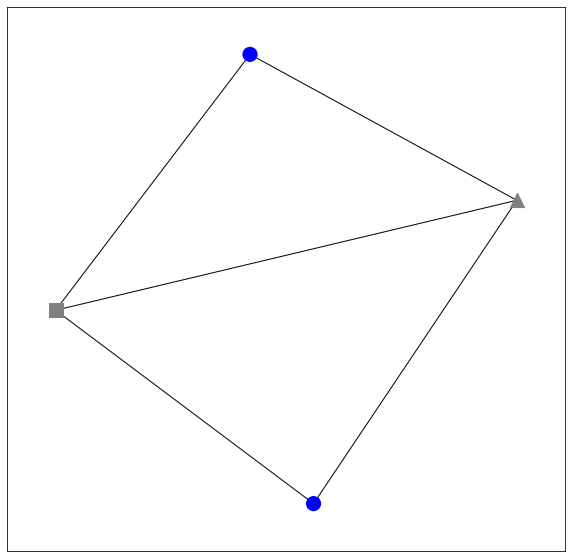

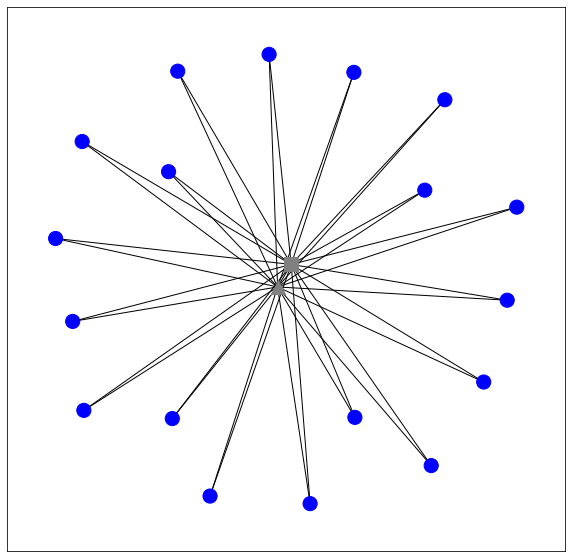

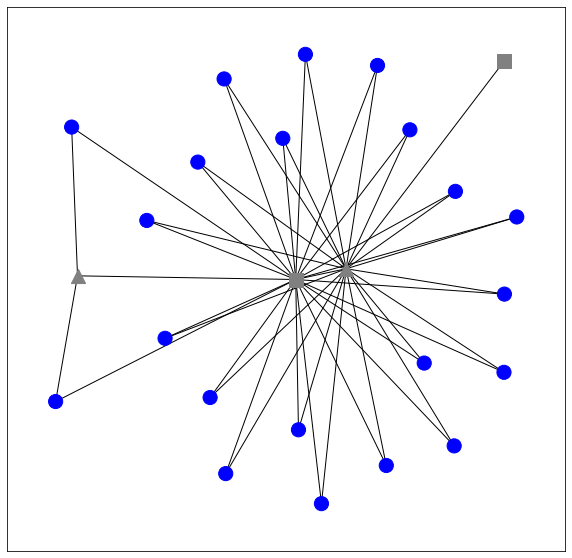

In [56]:
plot_neighborhood(dataloader_legit, N_plots=5)

## fraud

In [57]:
dataloader_fraud = DataLoader(
    hg, {'txnIdx': np.where(y_txn==1)[0]}, sampler,
    batch_size=1, shuffle=False, drop_last=False, num_workers=0)

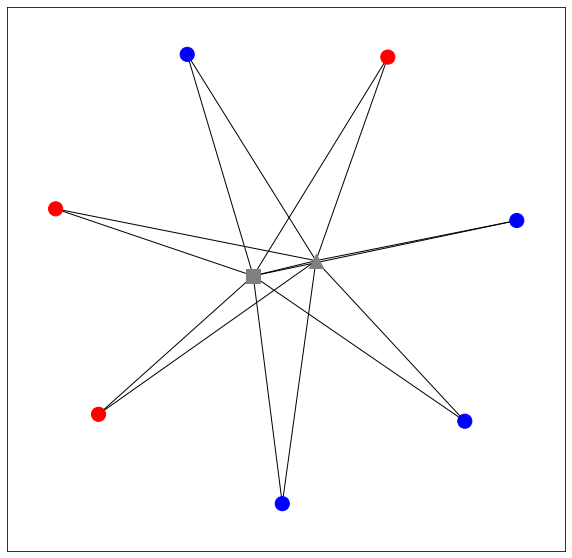

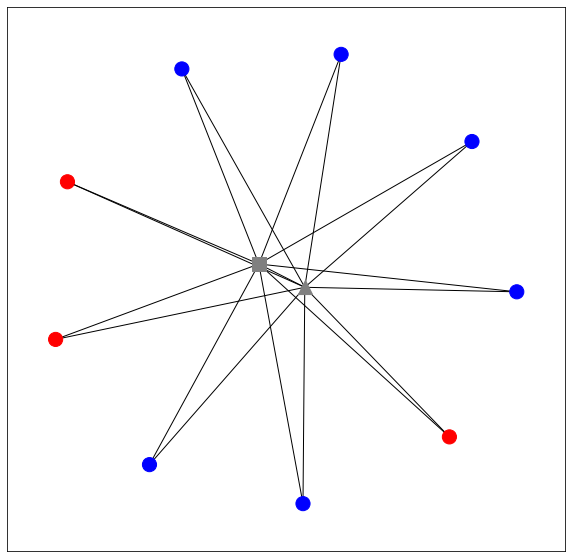

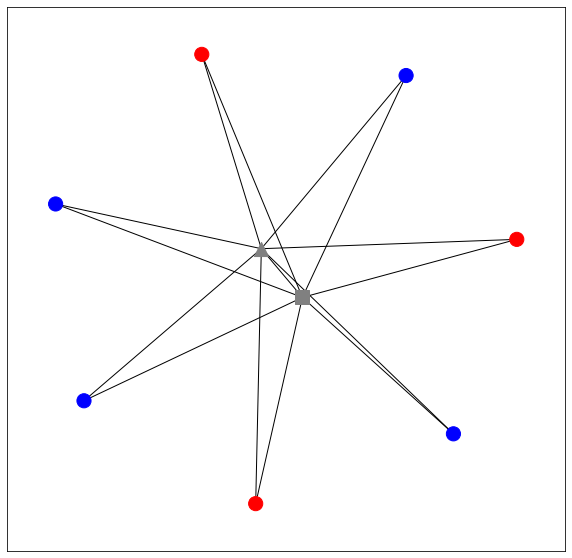

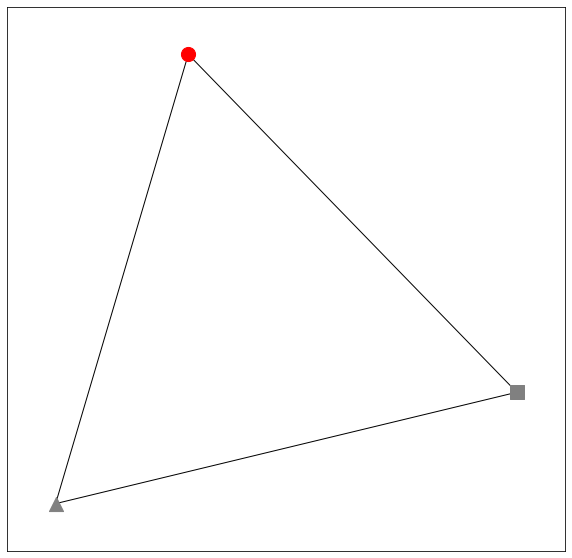

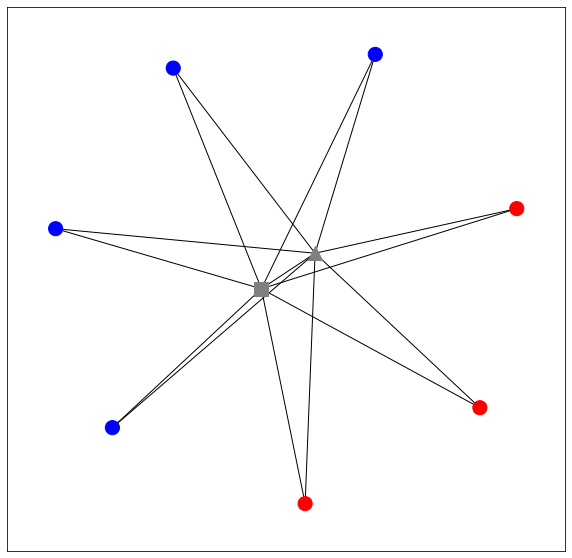

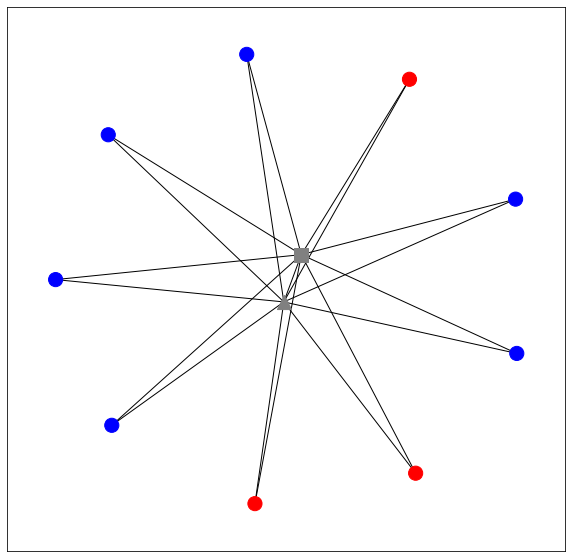

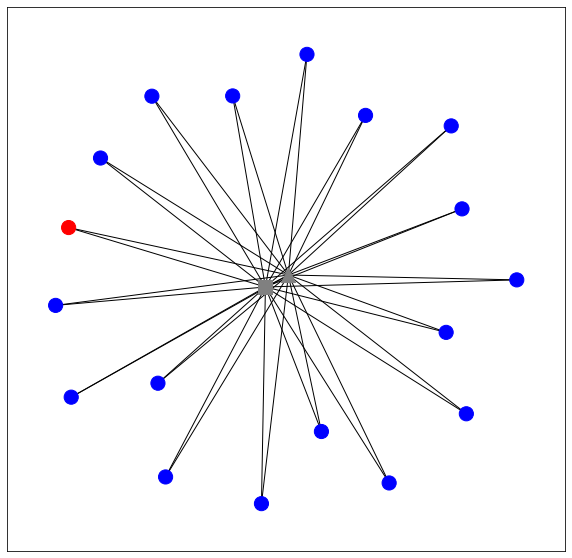

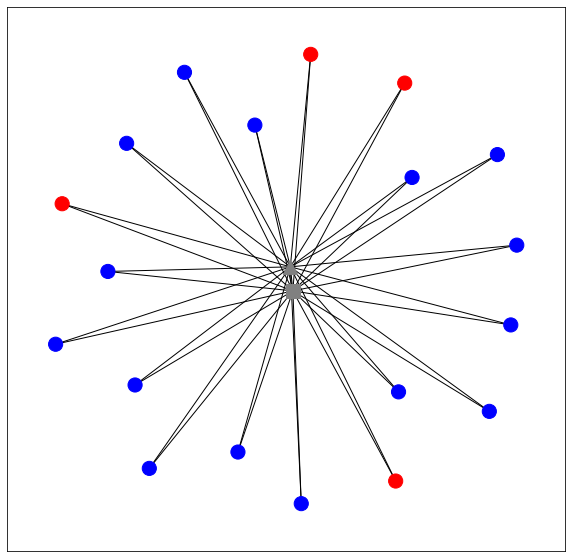

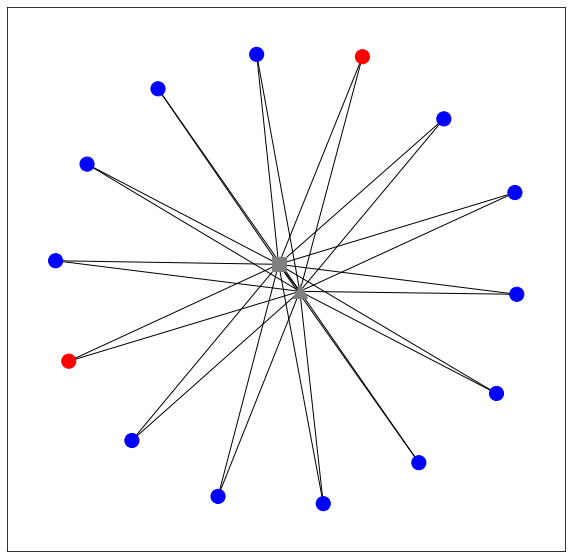

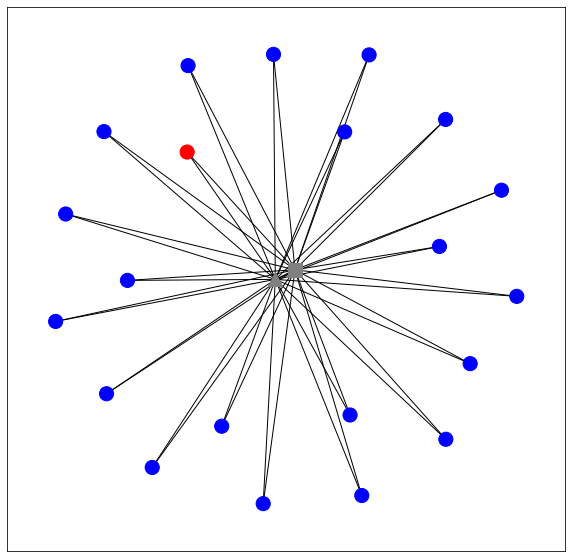

In [58]:
plot_neighborhood(dataloader_fraud, N_plots=10)

## node statistics

## node featuers

In [59]:
df.nunique().sort_values(ascending=False)

TransactionId           140681
txnIdx                  140681
BatchId                 139493
TransactionStartTime    138574
custIdx                   7479
CustomerId                7479
AccountId                 4841
acctIdx                   4841
SubscriptionId            4836
subIdx                    4836
Amount                    2099
Value                     1880
ProductId                   27
ProductCategory             10
ProviderId                   6
ChannelId                    5
PricingStrategy              4
FraudResult                  2
dataset                      2
CurrencyCode                 1
CountryCode                  1
dtype: int64

In [60]:
df.head(1).T

,0
TransactionId,TransactionId_76871
BatchId,BatchId_36123
AccountId,AccountId_3957
SubscriptionId,SubscriptionId_887
CustomerId,CustomerId_4406
CurrencyCode,UGX
CountryCode,256
ProviderId,ProviderId_6
ProductId,ProductId_10
ProductCategory,airtime


In [61]:
!cat dataset/Xente_Variable_Definitions.csv

Column Name,Definition
TransactionId,Unique �transaction identifier on platform
BatchId,Unique number assigned to a batch of transactions for processing
AccountId,Unique number identifying the customer on platform
SubscriptionId,Unique number identifying the customer subscription
CustomerId,Unique identifier attached to Account
CurrencyCode,Country currency
CountryCode,Numerical geographical code of country
ProviderId,Source provider of Item �bought.
ProductId,Item name being bought.
ProductCategory,ProductIds are organized into these broader product categories.
ChannelId,"Identifies if customer used web,Android, IOS, pay later or checkout."
Amount,Value of the transaction. Positive for debits from customer account and negative for credit into customer account
Value,Absolute value of the amount
TransactionStartTime,Transaction start time
PricingStrategy,Category of Xente's pricing structure for merchants
FraudResult,Fraud status of transaction 1 -yes or 0-No


In [62]:
categorical = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']

In [63]:
x_ohe = pd.get_dummies(df[categorical].astype(str), drop_first=True).values
# Amount,Value of the transaction
## Positive for debits from customer account 
## negative for credit into customer account
x_amt = ((df['Amount']>0)*1).values
x_value = df['Value'].apply(np.log10).values

In [64]:
X_num = np.concatenate([x_amt.reshape((-1,1)), x_value.reshape((-1,1))], axis=1)
X_num = (X_num - X_num.mean(axis=0))/(X_num.max(axis=0) - X_num.min(axis=0))

In [65]:
X = np.concatenate([x_ohe, X_num], axis=1)

In [66]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.40121267, -0.00782616],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.59878733, -0.26164142],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.40121267, -0.05279812],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.40121267,  0.14156744],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.59878733,  0.09659549],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.40121267,  0.07345412]])

In [67]:
# Indicies w/ labels (training data)
labeled_mask = np.zeros_like(y_txn, dtype=bool)
labeled_mask[:N_labels] = 1
assert y_txn[labeled_mask].mean()==baseline

# Split of training data into train/validation sets
rng = np.random.default_rng(1)
train_rate = 0.7
train_mask = (rng.random(y_txn.shape[0])>(1-train_rate))&labeled_mask
val_mask = ~train_mask&labeled_mask

test_mask = ~labeled_mask


# Modeling

In [68]:
from dgl.nn import GraphConv, HeteroGraphConv, WeightBasis

In [69]:
def plot_losses(train_losses, val_losses, log=False, title=False, **kwargs):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(train_losses, label='Train')
    ax.plot(val_losses, label='Val')
    ax.set(xlabel='Epoch',
          ylabel='CrossEnt')
    if log:
        ax.set_yscale('log')
    if title:
        ax.set_title(list(kwargs.values())[0])
    ax.legend()
    ax.grid()
    
@th.no_grad()
def infer(model_cp, hg, mask, best_model_fp=None):
    if best_model_fp:
        print('loading from disk')
        model = deepcopy(model_cp)
        model.load_state_dict(th.load(bets_model_fp))
    else:
        model = model_cp
    
    model.to(device)
    
    model.eval()
    
    features = hg.ndata['feat']
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([15] * len(model.convs))
    
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(mask)[0]}, sampler,
        batch_size = 1024, shuffle=False, drop_last=False, num_workers=0
    )
    
    y_preds = list()
    
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]
        
        logits = model(blocks, h)
        y_preds.append(logits.softmax(dim=1))
        
    return th.cat(y_preds).cpu()

@th.no_grad()
def test(model, hg, mask, best_path=None):
    
    model.eval()
    
    features = hg.ndata['feat']
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([15] * len(model.convs))
    
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(mask)[0]}, sampler,
        batch_size = 1024, shuffle=False, drop_last=False, num_workers=0
    )
    
    labels = hg.ndata['label']['txnIdx'].long()
    
    correct = list()
    
    ### attention
    #### dataloader function major role 
    #### https://docs.dgl.ai/en/latest/generated/dgl.dataloading.DataLoader.html#dgl.dataloading.DataLoader
    '''
    To train a 3-layer GNN for node classification 
    on a set of nodes train_nid on a homogeneous graph where each node takes messages from 15 neighbors on the first layer,
    10 neighbors on the second, and 5 neighbors on the third (assume the backend is PyTorch):
    sampler = [[15, 10 ,5 ]]

    '''
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]
        
        logits = model(blocks, h)
        y_preds = logits.argmax(1)
        n_correct = (labels[output_nodes['txnIdx']] == y_preds).sum().item()
        correct.append((labels[output_nodes['txnIdx']]==y_preds).sum().item())
        
    acc = sum(correct)/(th.where(mask)[0].shape[0])
    
    return acc

def train_step(model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight=False):
    model.train()
    optimizer.zero_grad()
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(train_mask)[0]}, sampler,
        batch_size=1024, shuffle=True, drop_last=False, num_workers=0
    )
    
    val_loader = DataLoader(
        hg, {'txnIdx': th.where(val_mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0
    )
    
    train_losses = list()
    
    if weight:
        weight = th.tensor([1. , 1 / baseline]).float().to(device)
    else:
        weight = None
    
    labels = hg.ndata['label']['txnIdx'].long()
    
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]
        
        logits = model(blocks, h)
        loss = loss_fn(logits, labels[output_nodes['txnIdx']], weight=weight)
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), 1.0)
        optimizer.step()
        train_losses.append(loss.item())
        
    val_losses = list()
    with th.no_grad():
        for input_nodes, output_nodes, blocks in val_loader:
            h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
            blocks = [b.to(device) for b in blocks]
            
            logits = model(blocks, h)
            val_loss = loss_fn(logits, labels[output_nodes['txnIdx']])
            val_losses.append(val_loss.item())
            
    return np.array(train_losses).mean(), np.array(val_losses).mean()
    
    
#####################
'''
this lines show u how consists of the dgl train procedure and to train the model.

'''
#####################
def train(hg, split_idx, model, epochs, evaluator,
         device, save_path, loss_fn=F.cross_entropy, lr=0.01,
         es_criteria=5, weight_class=False, verbose=False
         ):
    r''' train argument
    hg : heterogeneous graph
    split_idx : for splitting train , test , val dataset
    model : GNN
    epochs : hyperparameter for how train the model (iterative manner)
    evaluator : evalatuion for the results of the model
    device : GPU or CPU selection
    save_path ; for capture the best condition(result) model and to save the designated path
    loss_fn ; comparision standard between prediction results and ground truth
    lr ; 
    es_crietria ; early stopping criteria
    weight_class ; for handling the imbalanced dataset
    verbose ; whether watch or not the experiment log
    '''
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_metric = 1e10
    train_losses = list()
    val_losses = list()
    
    features = hg.ndata['feat']
    
    train_mask = split_idx['train'].to(device)
    val_mask = split_idx['valid'].to(device)
    es_iters = 0
    
    for e in range(1, epochs+1):
        
        train_loss, val_loss = train_step(
            model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight_class
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        train_acc = test(model, hg, train_mask)
        val_acc = test(model, hg, val_mask)
        
        val_metric = val_loss
        
        if val_metric > 1e5:
            print(f'Early stopping for huge loss : {val_metric}')
            break
            
        if val_metric < best_val_metric:
            best_val_metric = val_metric
            th.save(model.state_dict(), save_path)
            es_iters = 0
        else:
            es_iters += 1
        
        if e % 5 == 0 and verbose:
            
            print('In epoch {}, loss: {:.3f}, val metric: {:.3f} (best {:.3f})'.format(
                e, train_loss, val_metric, best_val_metric))
            
        if es_iters >= es_criteria:
            print(f"Early stopping at {e} epochs")
            break
            
    return np.array(train_losses), np.array(val_losses)

In [70]:
class RelGraphConvLayer(nn.Module):
    # https://github.com/dmlc/dgl/blob/master/tutorials/models/1_gnn/4_rgcn.py
    r''' Relation graph convolution layer.
    Parameters
    ----------
    in_feat ; int
        Input featuer size.
    out_feat ; int
        Output feature size.
    rel_names ; list[str]
        Relation names.
    num_bases ; int, optional
        Number of bases. If is none, use number of relations. Default ; None.
    weight ; bool, optional
        True if a linear layer is applied after message passing. Default ; True.
    bias ; bool, optional
        True if bias is added. Default ; True
    activation ; callable. optional
        Activaion function. Defulat ; None
    self_loop ; bool, optional
        True to include self loop message. Default ; False
    dropout ; float, optional
        Dropout rate, Default ; 0.0
    '''
    def __init__(self,
                in_feat,
                out_feat,
                rel_names,
                * ,
                num_bases=None,
                weight=True,
                bias=True,
                activation=None,
                self_loop=False,
                bn=False,
                dropout=0.0
                ):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.bn = bn
        
        ## heterographconv --> wrapping function
        
        self.conv = HeteroGraphConv({
            rel : GraphConv(in_feat, out_feat, norm='right', weight=False, bias=False)
            for  rel in rel_names
        })
        
        self.use_weight = weight
        self.use_basis = num_bases is not None and num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))
            
        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)
            
        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tesnor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                   gain=nn.init.calculate_gain('relu'))
        
        if self.bn:
            self.bn_layer = nn.BatchNorm1d(out_feat)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, g, inputs):
        '''forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            input graph
        inputs ; dict[str, torch.Tensor]
            node feature for each node type.
        Return
        ------
        dict[str, torch.Tensor]
            New node features for each node type.
        '''
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                    for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}
            
        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs
        
        hs = self.conv(g, inputs, mod_kwargs=wdict)
        
        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}

In [102]:
class RGCN(nn.Module):
    def __init__(self, hg, in_feats, h_feats, num_classes, num_layers, num_bases, 
                 self_loop=True, dropout=0, bn=False):

        super(RGCN, self).__init__()
        self.dropout = dropout
        
        # GNN layers
        self.convs = nn.ModuleList()
        activation_fn = nn.ReLU()
        self.convs.append(RelGraphConvLayer(
            in_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout, 
            num_bases=num_bases, self_loop=self_loop, bn=bn))

        for _ in range(num_layers-1):
            self.convs.append(RelGraphConvLayer(
                h_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout, 
                num_bases=num_bases, self_loop=self_loop, bn=bn
            ))
        
        # Output linear layer
        self.output_layer = nn.Linear(h_feats+in_feats, num_classes)

    def forward(self, blocks, in_feat):
        """
        The forward pass of the model, which applies all of the layers
        to a given graph and set of node features
        
        Args:
            g (DGLGraph): the graph used for Graph Convolutions
            in_feat (Tensor): the node features
        """
        h = in_feat
        for i, conv in enumerate(self.convs):
            h = conv(blocks[i], h)

        h_in = blocks[-1].dstdata['feat']['txnIdx']
        h = self.output_layer(th.cat([h['txnIdx'], h_in], dim=1))
        return h

# label smoothing blog
## https://ratsgo.github.io/insight-notes/docs/interpretable/smoothing
    
class LabelSmoothing(nn.Module):
    """NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.0):
        """Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        
    def forward(self, x, target, weight=None):
        logprobs = nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


In [72]:
for ntype in hg.ntypes:
    if ntype=='txnIdx':
        X_tmp = th.tensor(X).float() # the natural features
    else:
        # random values as features
#         X_rand = th.zeros((hg.num_nodes(ntype), X.shape[1]-1))
        X_rand = th.rand((hg.num_nodes(ntype), X.shape[1]-1))-0.5

        print(ntype, hg.num_nodes(ntype))
        in_degrees = th.zeros(hg.num_nodes(ntype))
        for cetype in hg.canonical_etypes:
            if ntype==cetype[2]:
                print(cetype)
                in_degrees += hg.in_degrees(etype=cetype)
        in_degrees = th.log(in_degrees).reshape((-1, 1))
        in_degrees -= in_degrees.mean()

        X_tmp = th.hstack([X_rand, in_degrees])
    hg.nodes[ntype].data['feat'] = X_tmp

acctIdx 4841
('subIdx', 'subIdx-acctIdx', 'acctIdx')
('txnIdx', 'txnIdx-acctIdx', 'acctIdx')
subIdx 4836
('acctIdx', 'acctIdx-subIdx', 'subIdx')
('txnIdx', 'txnIdx-subIdx', 'subIdx')


In [73]:
split_mask = {
    'train': th.tensor(train_mask),
    'valid': th.tensor(val_mask),
    'test': th.tensor(test_mask)
}

In [74]:
loss_fn = LabelSmoothing(smoothing=0.1)

In [75]:
model_kwargs = dict(
    in_feats=X.shape[1], h_feats=256, num_classes=2, 
    num_layers=2, dropout=0.1, num_bases=None,
    self_loop=False, bn=True,
)
device = 'cuda'

model = RGCN(hg, **model_kwargs).to(device)
model

RGCN(
  (convs): ModuleList(
    (0): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (acctIdx-subIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (acctIdx-txnIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (subIdx-acctIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (subIdx-txnIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (txnIdx-acctIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (txnIdx-subIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
        )
      )
      (bn_layer): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (acctIdx-subI

In [76]:
train_losses, val_losses = train(
    hg.to(device), split_mask, model.to(device), 500, None, 
    device, 'models/rgcn.pt', loss_fn=loss_fn, lr=0.001, 
    es_criteria=50, verbose=True, weight_class=True,
)

/tmp/ipykernel_32566/3617112853.py:119: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), 1.0)


In epoch 5, loss: 0.220, val metric: 0.216 (best 0.210)
In epoch 10, loss: 0.203, val metric: 0.203 (best 0.203)
In epoch 15, loss: 0.204, val metric: 0.204 (best 0.203)
In epoch 20, loss: 0.204, val metric: 0.208 (best 0.203)
In epoch 25, loss: 0.202, val metric: 0.203 (best 0.203)
In epoch 30, loss: 0.204, val metric: 0.205 (best 0.203)
In epoch 35, loss: 0.203, val metric: 0.205 (best 0.203)
In epoch 40, loss: 0.202, val metric: 0.203 (best 0.203)
In epoch 45, loss: 0.205, val metric: 0.209 (best 0.203)
In epoch 50, loss: 0.204, val metric: 0.206 (best 0.203)
In epoch 55, loss: 0.204, val metric: 0.208 (best 0.203)
In epoch 60, loss: 0.204, val metric: 0.205 (best 0.203)
In epoch 65, loss: 0.203, val metric: 0.205 (best 0.203)
In epoch 70, loss: 0.203, val metric: 0.204 (best 0.203)
Early stopping at 74 epochs


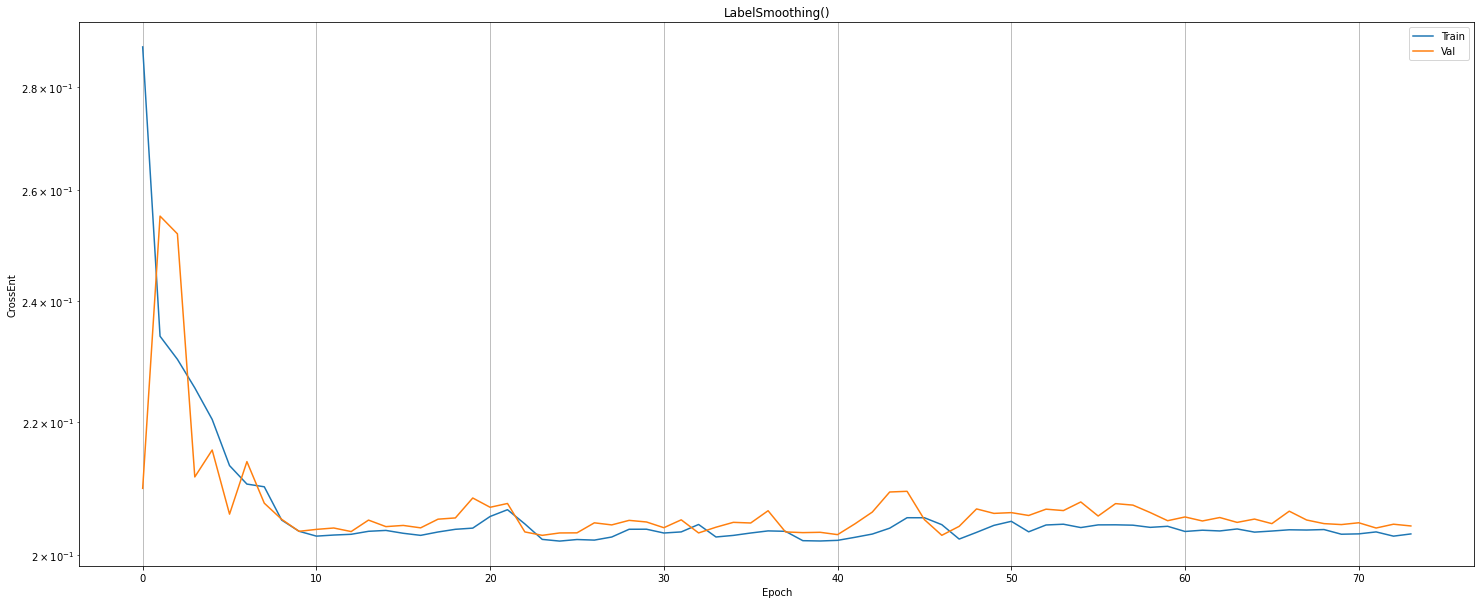

In [104]:
plot_losses(train_losses, val_losses, log=True, title=True, title_name=loss_fn.__repr__())

In [107]:
loss_fn=F.cross_entropy
print(loss_fn.__repr__())

<function cross_entropy at 0x7f664e9ff0d0>


In [109]:
train_losses, val_losses = train(
    hg.to(device), split_mask, model.to(device), 500, None, 
    device, 'models/rgcn.pt', loss_fn=loss_fn, lr=0.001, 
    es_criteria=50, verbose=True, weight_class=True,
)

/tmp/ipykernel_32566/3617112853.py:119: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), 1.0)


In epoch 5, loss: 0.086, val metric: 0.075 (best 0.060)
In epoch 10, loss: 0.143, val metric: 0.047 (best 0.047)
In epoch 15, loss: 0.064, val metric: 0.053 (best 0.025)
In epoch 20, loss: 0.046, val metric: 0.054 (best 0.025)
In epoch 25, loss: 0.066, val metric: 0.052 (best 0.025)
In epoch 30, loss: 0.037, val metric: 0.045 (best 0.025)
In epoch 35, loss: 0.030, val metric: 0.052 (best 0.025)
In epoch 40, loss: 0.090, val metric: 0.052 (best 0.025)
In epoch 45, loss: 0.033, val metric: 0.056 (best 0.025)
In epoch 50, loss: 0.031, val metric: 0.039 (best 0.025)
In epoch 55, loss: 0.028, val metric: 0.047 (best 0.025)
In epoch 60, loss: 0.024, val metric: 0.041 (best 0.025)
Early stopping at 63 epochs


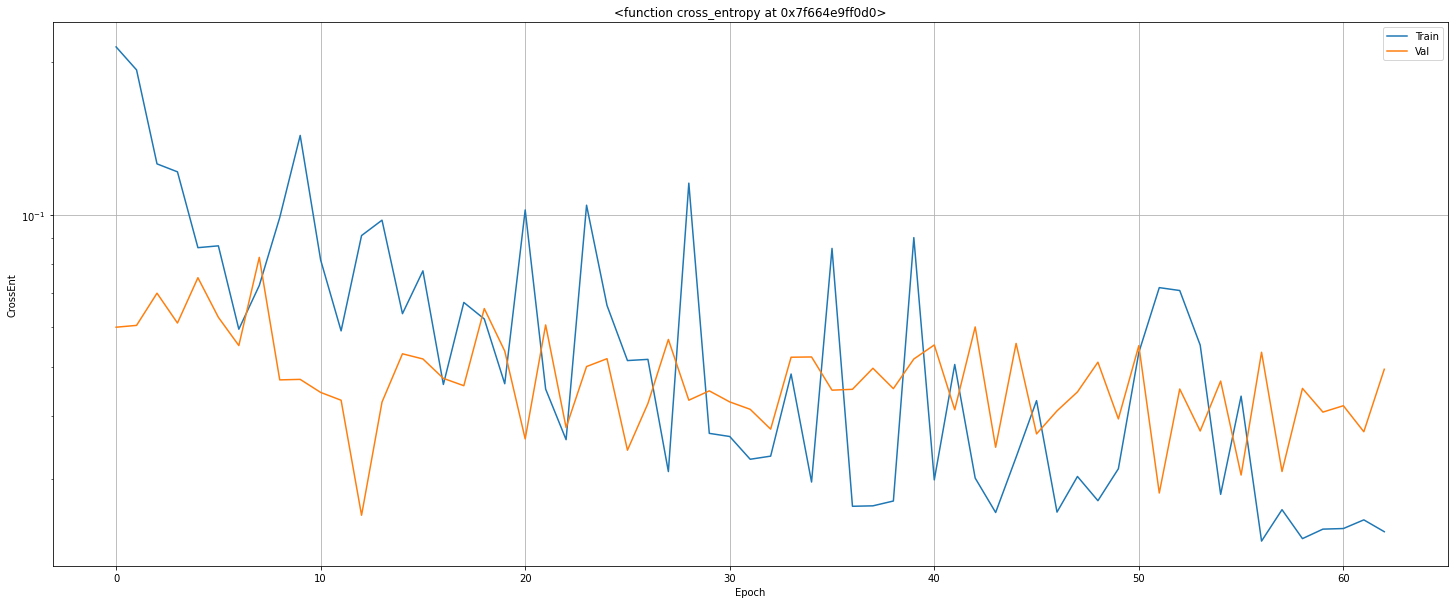

In [110]:
plot_losses(train_losses, val_losses, log=True, title=True, title_name=loss_fn.__str__())

In [114]:
dir(hg)

['__class__',
 '__contains__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_num_edges',
 '_batch_num_nodes',
 '_canonical_etypes',
 '_dsttypes_invmap',
 '_edge_frames',
 '_etype2canonical',
 '_etypes',
 '_etypes_invmap',
 '_find_etypes',
 '_get_e_repr',
 '_get_n_repr',
 '_graph',
 '_idtype_str',
 '_init',
 '_is_unibipartite',
 '_node_frames',
 '_ntypes',
 '_pop_e_repr',
 '_pop_n_repr',
 '_reset_cached_info',
 '_set_e_repr',
 '_set_n_repr',
 '_srctypes_invmap',
 'add_edge',
 'add_edges',
 'add_nodes',
 'add_self_loop',
 'adj',
 'adj_sparse',
 'adjacency_matrix',
 'adjacency_matrix_scipy',
 'all_edges',
 'apply_edges',
 'apply_n

In [120]:
hg.metagraph

<bound method DGLHeteroGraph.metagraph of Graph(num_nodes={'acctIdx': 4841, 'subIdx': 4836, 'txnIdx': 140681},
      num_edges={('acctIdx', 'acctIdx-subIdx', 'subIdx'): 4843, ('acctIdx', 'acctIdx-txnIdx', 'txnIdx'): 140681, ('subIdx', 'subIdx-acctIdx', 'acctIdx'): 4843, ('subIdx', 'subIdx-txnIdx', 'txnIdx'): 140681, ('txnIdx', 'txnIdx-acctIdx', 'acctIdx'): 140681, ('txnIdx', 'txnIdx-subIdx', 'subIdx'): 140681},
      metagraph=[('acctIdx', 'subIdx', 'acctIdx-subIdx'), ('acctIdx', 'txnIdx', 'acctIdx-txnIdx'), ('subIdx', 'acctIdx', 'subIdx-acctIdx'), ('subIdx', 'txnIdx', 'subIdx-txnIdx'), ('txnIdx', 'acctIdx', 'txnIdx-acctIdx'), ('txnIdx', 'subIdx', 'txnIdx-subIdx')])>

## Further work

GRAPH SMOTE

[official_github](https://github.com/TianxiangZhao/GraphSmote)

# coder info , brief introduction

### network lover, passionate about GNN

## ii tae jeong , jeongiitae6@gmail.com


# original code ; [link](https://github.com/zjost/blog_code/blob/master/tab2graph_fraud/xente_tabular_to_graph.ipynb)

thanks to @zak allow me the reuse great resource at this tutorial 